In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from haversine import haversine
from scoretools import freq_tab
from scoretools import single_bivar
from sklearn.preprocessing import OneHotEncoder 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import pickle
import lightgbm as lgb


## 0. Upfront Questions

* Do we know what type(s) of fraud is on the dataset
* How are the customers reporting fraud (push notifications, reporting it later)?

In [2]:
pd.options.display.float_format = '{:.3f}'.format

## 1. Data Loading and Cleaning

In [3]:
df_train = pd.read_csv('data/tr_fincrime_train.csv')
#df_train = df_train.sample(200000)
df_train.shape

(1296675, 23)

In [4]:
# sanity check
df_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970,Jennifer,Banks,F,561 Perry Cove,...,36.079,-81.178,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011,-82.048,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.888,-118.210,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159,-118.186,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110,Edward,Sanchez,M,594 White Dale Suite 530,...,42.181,-112.262,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.151,-112.154,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.231,-112.114,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034,-112.561,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960,Tyler,Garcia,M,408 Bradley Rest,...,38.421,-79.463,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.675,-78.632,0


In [5]:
# remove first column
df_train = df_train.iloc[:, 1:]

In [6]:
# check for missing data
df_train.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [7]:
# check data types
df_train.dtypes

trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [8]:
# assign time variables to datetime
df_train['trans_date_trans_time'] = pd.to_datetime(df_train.trans_date_trans_time)
df_train['trans_date'] = pd.to_datetime(df_train['trans_date_trans_time'].dt.date)
df_train['dob'] = pd.to_datetime(df_train.dob)

In [9]:
# check data timeframe
print('Start Date: ', df_train.trans_date.min())
print('End Date:   ', df_train.trans_date.max())

Start Date:  2019-01-01 00:00:00
End Date:    2020-06-21 00:00:00


In [10]:
# Check for zip length
## When the data was converted to CSV, the leading 0 is often dropped from zip code, making it an invalid (4 digit) zipcode

df_train['zip'] = df_train['zip'].astype(str)

df_train.zip.apply(len).value_counts()

zip
5    1214893
4      81782
Name: count, dtype: int64

In [11]:
# Fill in leading zeros

df_train['zip'] = df_train.zip.str.zfill(5)
print(df_train.zip.apply(len).value_counts())

zip
5    1296675
Name: count, dtype: int64


In [12]:
# Check credit card number lengths

df_train['cc_num'] = df_train['cc_num'].astype(str)
df_train.cc_num.apply(len).value_counts()

cc_num
16    649148
15    215968
14    125985
19    118789
12     91468
13     89206
11      6111
Name: count, dtype: int64

In [13]:
# check unique value counts
df_train.nunique()

trans_date_trans_time    1274791
cc_num                       983
merchant                     693
category                      14
amt                        52928
first                        352
last                         481
gender                         2
street                       983
city                         894
state                         51
zip                          970
lat                          968
long                         969
city_pop                     879
job                          494
dob                          968
trans_num                1296675
unix_time                1274823
merch_lat                1247805
merch_long               1275745
is_fraud                       2
trans_date                   537
dtype: int64

In [14]:
# Check out the categorical columns
cat_cols = list(df_train.dtypes[df_train.dtypes == 'object'].index)

for col in cat_cols:
    print(df_train[col].value_counts()[:10])


cc_num
4512828414983801773    3123
571365235126           3123
36722699017270         3119
213112402583773        3117
3545109339866548       3113
6534628260579800       3112
6011367958204270       3110
2720433095629877       3107
6011438889172900       3106
6011109736646996       3101
Name: count, dtype: int64
merchant
fraud_Kilback LLC                   4403
fraud_Cormier LLC                   3649
fraud_Schumm PLC                    3634
fraud_Kuhn LLC                      3510
fraud_Boyer PLC                     3493
fraud_Dickinson Ltd                 3434
fraud_Cummerata-Jones               2736
fraud_Kutch LLC                     2734
fraud_Olson, Becker and Koch        2723
fraud_Stroman, Hudson and Erdman    2721
Name: count, dtype: int64
category
gas_transport     131659
grocery_pos       123638
home              123115
shopping_pos      116672
kids_pets         113035
shopping_net       97543
entertainment      94014
food_dining        91461
personal_care      90758
health_f

In [15]:
# check out target variable
freq_tab(df_train.is_fraud)

,Frequency,Percent,Cumulative Frequency,Cumulative Percent
is_fraud,,,,
0,1289169,0.994,1289169,0.994
1,7506,0.006,1296675,1.000


## 2. Exploratory Data Analysis

In [16]:
# Check if there are multiple names or address on each card
# A recent address change is a strong fraud indicator

df_train['address'] = df_train['street'] + ' ' + df_train['city'] + ' ' + df_train['state'] + ' ' + df_train.zip
df_train['first_last'] = df_train['first'] + ' ' + df_train['last']

df_grouped = df_train.groupby('cc_num')

# number of addresses associated with card
# Recent address change
num_addr = df_grouped['address'].nunique()
num_names = df_grouped['first_last'].nunique()

print(num_addr.value_counts())
print(num_names.value_counts())


address
1    983
Name: count, dtype: int64
first_last
1    983
Name: count, dtype: int64


#### Analysis by Time

In [17]:
df_train['f_month'] = df_train.trans_date.dt.month
df_train['f_dayofweek'] = df_train.trans_date.dt.dayofweek
df_train['f_weekday'] = df_train.trans_date.dt.weekday
df_train['hour'] = df_train.trans_date_trans_time.dt.hour

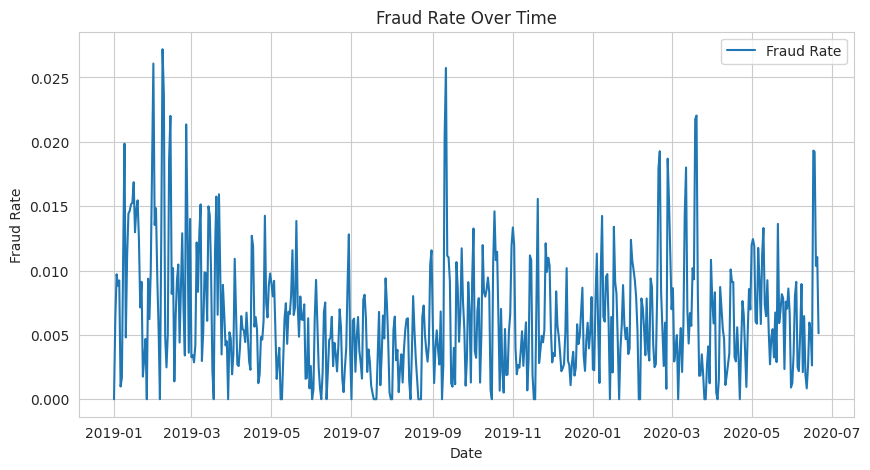

In [18]:
# check out fraud trends by date

daily_fraud_rate = df_train.groupby('trans_date')['is_fraud'].mean().reset_index()


# Set the style for the plots
sns.set_style("whitegrid")


# Plotting sales trends
plt.figure(figsize=(10, 5))
plt.plot(daily_fraud_rate['trans_date'], daily_fraud_rate['is_fraud'], label='Fraud Rate')
plt.title('Fraud Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Fraud Rate')
plt.legend()
plt.show()

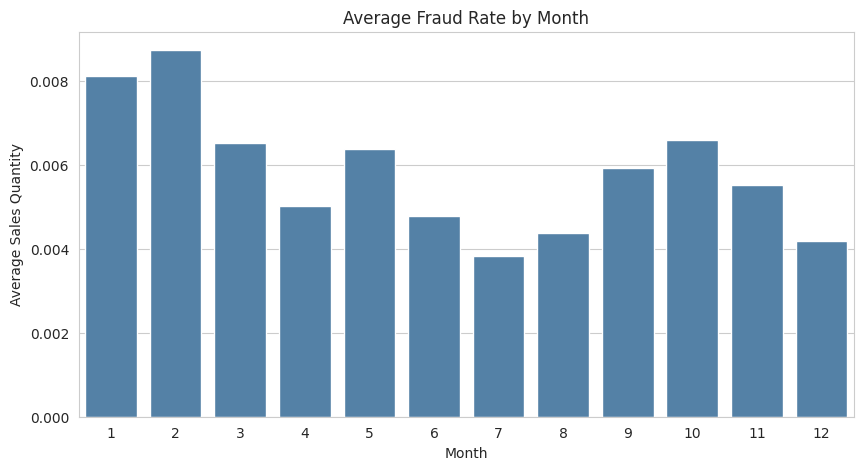

In [19]:
# Check out monthly sales for seasonality
monthly_sales = df_train.groupby('f_month')['is_fraud'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='f_month', y='is_fraud', data=monthly_sales, color = 'steelblue')
plt.title('Average Fraud Rate by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales Quantity')
plt.show()
del monthly_sales

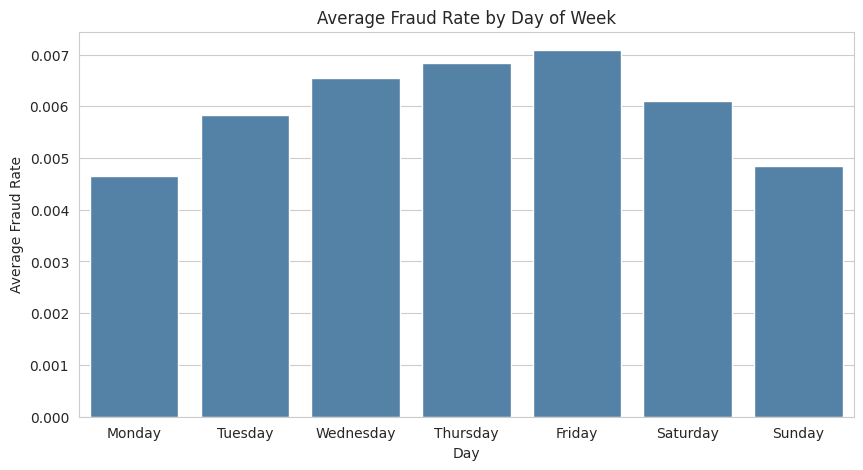

In [20]:
# Check out dayofweek sales
dayofweek_sales = df_train.groupby('f_dayofweek')['is_fraud'].mean().reset_index()

plt.figure(figsize=(10, 5))
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x='f_dayofweek', y='is_fraud', data=dayofweek_sales, color = 'steelblue', errorbar=None, order=range(7))
plt.title('Average Fraud Rate by Day of Week')
plt.xlabel('Day')
plt.ylabel('Average Fraud Rate')
plt.xticks(range(7), days)
plt.show()
del dayofweek_sales

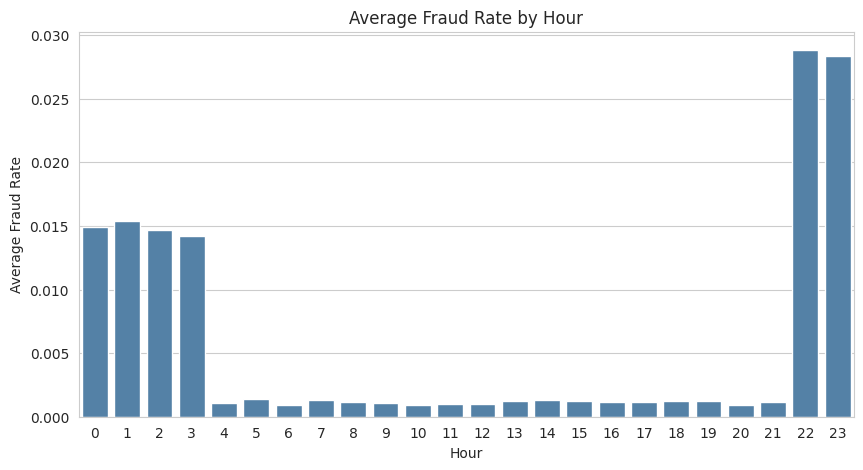

In [21]:
# Check out monthly sales for seasonality
monthly_sales = df_train.groupby('hour')['is_fraud'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='hour', y='is_fraud', data=monthly_sales, color = 'steelblue')
plt.title('Average Fraud Rate by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Fraud Rate')
plt.show()
del monthly_sales

In [22]:
# Check days with highest fraud rate
daily_fraud_rate.sort_values(by='is_fraud', ascending=False).iloc[:10]
del daily_fraud_rate

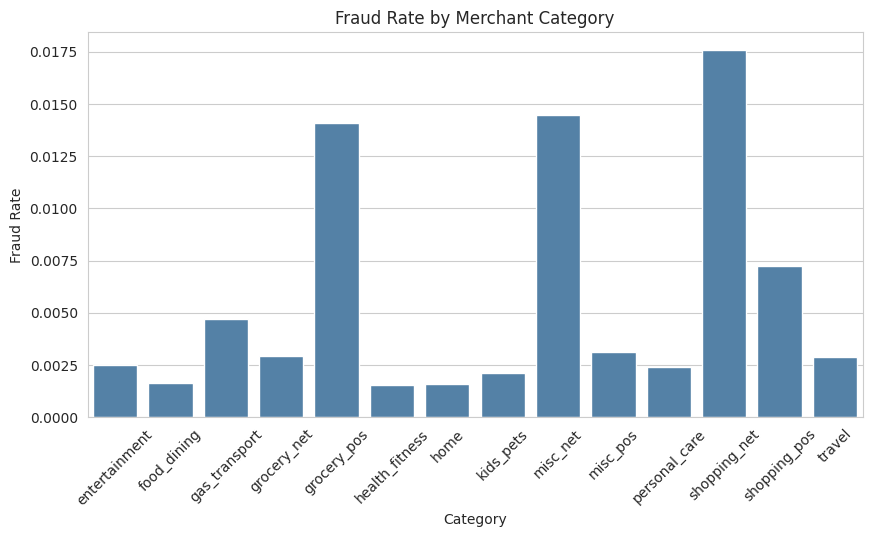

In [23]:
# Fraud rate by category
category_fraud = df_train.groupby('category')['is_fraud'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='category', y='is_fraud', data=category_fraud, color = 'steelblue')
plt.title('Fraud Rate by Merchant Category')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.ylabel('Fraud Rate')
plt.show()
del category_fraud

/tmp/ipykernel_822/3821796405.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_bin = df_train.groupby('amt_bins')['is_fraud'].mean()


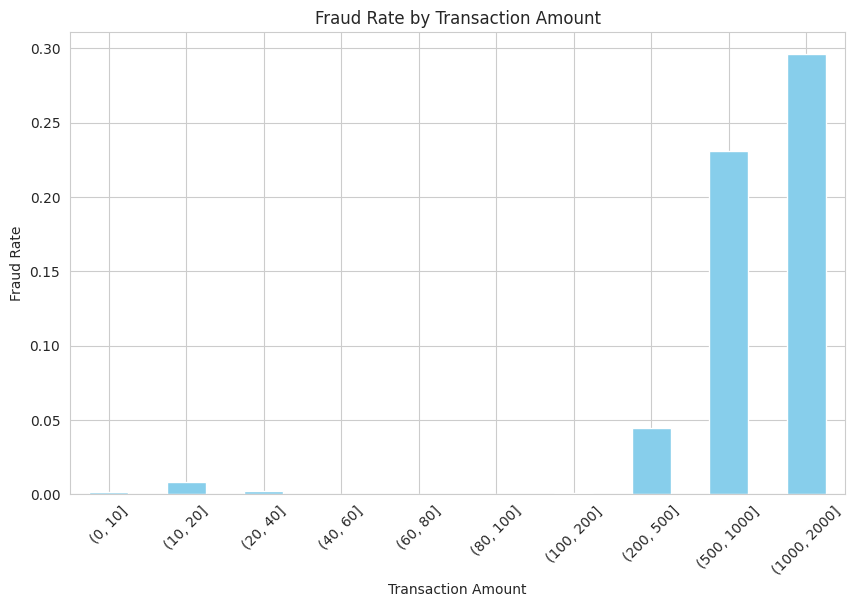

In [24]:
df_train['amt_bins'] = pd.cut(df_train.amt, bins=[0,10,20,40,60,80,100,200,500,1000,2000])

# Calcualte fraud rates by group
fraud_rate_by_bin = df_train.groupby('amt_bins')['is_fraud'].mean()

# Plotting
plt.figure(figsize=(10, 6))
fraud_rate_by_bin.plot(kind='bar', color='skyblue')
plt.xlabel('Transaction Amount')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Transaction Amount')
plt.xticks(rotation=45) 
plt.show()

del fraud_rate_by_bin

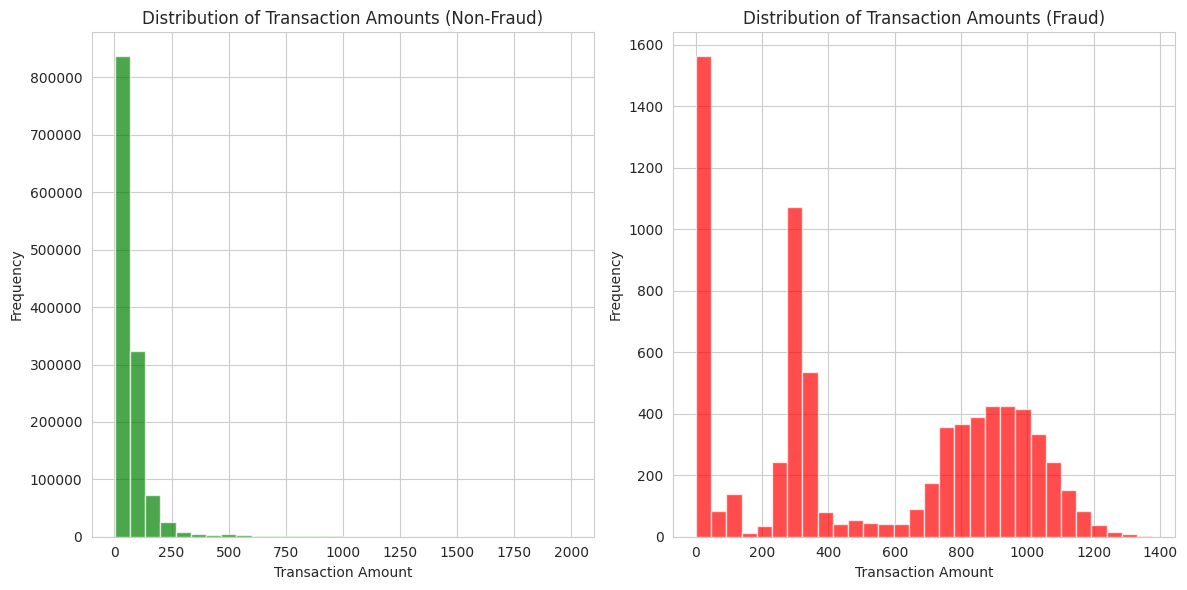

In [25]:
df_train_no_outlier = df_train.loc[df_train.amt < 2000, ['amt', 'is_fraud']]

fraud = df_train_no_outlier[df_train_no_outlier['is_fraud'] == 1]['amt']
non_fraud = df_train_no_outlier[df_train_no_outlier['is_fraud'] == 0]['amt']

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Plot histogram for non-fraud transactions
plt.subplot(1, 2, 1)  
plt.hist(non_fraud, bins=30, alpha=0.7, color='green')
plt.title('Distribution of Transaction Amounts (Non-Fraud)')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

# Plot histogram for fraud transactions
plt.subplot(1, 2, 2)  
plt.hist(fraud, bins=30, alpha=0.7, color='red')
plt.title('Distribution of Transaction Amounts (Fraud)')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

In [26]:
# jobs fraud rates

single_bivar(data=df_train, main_var='job', bivar='is_fraud').sort_values(by='is_fraud Rate', ascending=False).iloc[0:10]

,N,Pct N,is_fraud sum,is_fraud Rate,is_fraud Pct
job,,,,,
"Accountant, chartered",11.000,0.000,11.000,1.000,0.001
Sales promotion account executive,14.000,0.000,14.000,1.000,0.002
Dancer,19.000,0.000,19.000,1.000,0.003
Armed forces technical officer,8.000,0.000,8.000,1.000,0.001
Air traffic controller,17.000,0.000,17.000,1.000,0.002
Personnel officer,12.000,0.000,12.000,1.000,0.002
Solicitor,11.000,0.000,11.000,1.000,0.001
Ship broker,7.000,0.000,7.000,1.000,0.001
Contracting civil engineer,7.000,0.000,7.000,1.000,0.001


In [27]:
# Check how many people share the same job
df_train.groupby('job')['cc_num'].nunique().value_counts()

cc_num
1    202
2    163
3     80
4     35
5      9
6      5
Name: count, dtype: int64

#### Observations on zip code, city, job
* Features have high cardinality and low representation. Example: each zip code is represented by approximately 1 person
* Could cause overfitting if added othe model
* Given more time, jobs could be grouped
* Note: Zip and merchant will be used in other features


In [28]:
# merchant fraud rates
single_bivar(data=df_train, main_var='merchant', bivar='is_fraud').sort_values(by='is_fraud Rate', ascending=False).iloc[0:10]

,N,Pct N,is_fraud sum,is_fraud Rate,is_fraud Pct
merchant,,,,,
fraud_Kozey-Boehm,1866.000,0.001,48.000,0.026,0.006
"fraud_Herman, Treutel and Dickens",1300.000,0.001,33.000,0.025,0.004
fraud_Kerluke-Abshire,1838.000,0.001,41.000,0.022,0.005
fraud_Brown PLC,1176.000,0.001,26.000,0.022,0.003
fraud_Goyette Inc,1943.000,0.001,42.000,0.022,0.006
fraud_Terry-Huel,1996.000,0.002,43.000,0.022,0.006
fraud_Jast Ltd,1953.000,0.002,42.000,0.022,0.006
"fraud_Schmeler, Bashirian and Price",1968.000,0.002,41.000,0.021,0.005
fraud_Boyer-Reichert,1908.000,0.001,38.000,0.020,0.005


In [29]:
df_train.sort_values(by=['cc_num', 'trans_date_trans_time'], inplace=True)

In [30]:
df_train['prev_merchant'] = df_train.groupby('cc_num')['merchant'].shift(1)

# More time: pull all previous merchants in the last 7 days and see if there's a pattern

In [31]:
single_bivar(data=df_train, main_var='prev_merchant', bivar='is_fraud').sort_values(by='is_fraud Rate', ascending=False).iloc[0:10]

,N,Pct N,is_fraud sum,is_fraud Rate,is_fraud Pct
prev_merchant,,,,,
Missing,983.000,0.001,75.000,0.076,0.010
"fraud_Herman, Treutel and Dickens",1298.000,0.001,31.000,0.024,0.004
fraud_Kozey-Boehm,1861.000,0.001,43.000,0.023,0.006
fraud_Jast Ltd,1949.000,0.002,42.000,0.022,0.006
fraud_Goyette Inc,1943.000,0.001,40.000,0.021,0.005
fraud_Brown PLC,1176.000,0.001,23.000,0.020,0.003
"fraud_Tillman, Fritsch and Schmitt",1306.000,0.001,25.000,0.019,0.003
fraud_Kerluke-Abshire,1838.000,0.001,35.000,0.019,0.005
"fraud_Moore, Dibbert and Koepp",1264.000,0.001,24.000,0.019,0.003


In [34]:
# Identify theft fraud cases
# With more time: look at these fraud seperately. Possibly create a seperate model

first_trans = df_train.groupby('cc_num').first().reset_index()
first_trans = first_trans.loc[first_trans.is_fraud==1, ['cc_num']]
first_trans['ID_theft'] = 1
df_train = df_train.merge(first_trans, on='cc_num', how='left')
df_train.ID_theft = df_train.ID_theft.fillna(0)
print(df_train.ID_theft.value_counts())

del first_trans

ID_theft
0.000    1295934
1.000        741
Name: count, dtype: int64


## 3. Feature Engineering

In [35]:
# Create a function for data processessing

def process_data(df):

    df_temp = df.copy()
    # assign time variables to datetime
    df_temp['trans_date_trans_time'] = pd.to_datetime(df_temp.trans_date_trans_time)
    df_temp['trans_date'] = pd.to_datetime(df_temp['trans_date_trans_time'].dt.date)
    df_temp['dob'] = pd.to_datetime(df_temp.dob)

    # Check for zip length
    ## When the data was converted to CSV, the leading 0 is often dropped from zip code, making it an invalid (4 digit) zipcode

    df_temp['zip'] = df_temp['zip'].astype(str)

    df_temp.zip.apply(len).value_counts()

    # Fill in leading zeros

    df_temp['zip'] = df_temp.zip.str.zfill(5)

    # Check credit card number lengths

    df_temp['cc_num'] = df_temp['cc_num'].astype(str)

    df_temp['f_month'] = df_temp.trans_date.dt.month
    df_temp['f_dayofweek'] = df_temp.trans_date.dt.dayofweek
    df_temp['f_weekday'] = df_temp.trans_date.dt.weekday
    df_temp['hour'] = df_temp.trans_date_trans_time.dt.hour

    df_temp['f_timeofday'] = np.where((df_temp.hour >= 4) & (df_temp.hour <= 11), 'Morning', 
                                 np.where((df_temp.hour >=12) & (df_temp.hour <= 16), 'Afternoon',
                                 np.where((df_temp.hour >= 17) & (df_temp.hour <= 21), 'Evening', 'Night')))


    df_temp.sort_values(by=['cc_num', 'trans_date_trans_time'], inplace=True)

    ## Helper functions

    def roll_features(window, op):
        # Compute the rolling feature
        rolled = df_temp_grouped['amt'].rolling(window).agg(op)
        rolled = rolled.reset_index()
        feature_name = f'f_past_{window}_amt_{op}'
        df_temp_features[feature_name] = rolled['amt']

        # Add merging keys if not already present
        if 'cc_num' not in df_temp_features:
            df_temp_features['cc_num'] = rolled['cc_num']
            df_temp_features['trans_date_trans_time'] = rolled['trans_date_trans_time']


    def calculate_prev_distance(row):
        if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_long']):
            return haversine((row['prev_lat'], row['prev_long']), (row['merch_lat'], row['merch_long']), unit='mi')
            # Note: haversine is a litte less accurate than geopy but faster to calculate
        else:
            return np.nan
        



    ## Rolled Features - velocity ##

    # set index to time for rolling window calculations
    df_temp.set_index('trans_date_trans_time', inplace=True)

    # Group data by credit card number
    df_temp_grouped = df_temp.groupby('cc_num')

    # Initialize an empty DataFrame for rolled features
    df_temp_features = pd.DataFrame()

    # Loop over different rolling windows and operations
    time_windows = ['10T', '30T', '1H', '6H', '1D', '2D', '7D', '30D']
    operations = ['count', 'sum']

    for window in time_windows:
        for op in operations:
            roll_features(window, op)

    roll_features('60D', 'mean')
    roll_features('60D', 'std')



    # Merge features onto df_temp
    df_temp.reset_index(inplace=True)
    df_temp = df_temp.merge(df_temp_features, on=['cc_num', 'trans_date_trans_time'])


    # amt_z_score - z score using current amt and 60 day mean,std
    df_temp['f_amt_z_score'] = (df_temp['amt'] - df_temp['f_past_60D_amt_mean'])/df_temp['f_past_60D_amt_std']


    # past_frauds_cum - cumulative number of past frauds on cc
    ## Note: this feature might not be possible to use, depending on how frauds are reported
    #df_temp['f_past_frauds_cum'] = df_temp_grouped['is_fraud'].cumsum().groupby(df_temp['cc_num']).shift(fill_value=0)


    ## Location based features ##
    # dist_home_merch - Distance from home to merchant
    df_temp['f_dist_home_merch'] = df_temp.apply(
        lambda row: haversine((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])), axis=1
    )
    # Calculate distance to previous transaction
    df_temp['prev_lat'] = df_temp_grouped['merch_lat'].shift(1)
    df_temp['prev_long'] = df_temp_grouped['merch_long'].shift(1)
    df_temp['f_prev_trans_dist_diff'] = df_temp.apply(calculate_prev_distance, axis=1)

    # Calculate time difference in hours
    df_temp['f_prev_trans_time_diff'] = df_temp_grouped['trans_date_trans_time'].diff().dt.total_seconds() / 3600
    # Replace any 0s so we are not dividing by 0
    df_temp.f_prev_trans_time_diff.replace(0,1, inplace=True)

    # transaction_travel_speed - Calculate Transaction Travel Speed (miles/hr)
    df_temp['f_prev_trans_travel_speed'] = df_temp['f_prev_trans_dist_diff'] / df_temp['f_prev_trans_time_diff']


    ## Basic Features ##
    # Age of cc holder
    df_temp['f_age'] = (df_temp.trans_date.dt.year - df_temp.dob.dt.year) - ((df_temp.trans_date.dt.month - df_temp.dob.dt.month) < 0)

    # BIN - first 8 digits of CC
    df_temp['BIN'] = df_temp.cc_num.str[0:8]

    # MII - first digit of CC
    df_temp['f_MII'] = df_temp.cc_num.str[0:1]

    # business type - pulled from merchant name
    merchant_end = df_temp.merchant.str[-3:]
    bus_types = ['LLC', 'Inc', 'Ltd', 'PLC']
    df_temp['f_bus_type'] = np.where(merchant_end.isin(bus_types), merchant_end, 'Unknown')


    # flag_merchant_inconsistency - merchant has multiple locations - not using this
    #df_temp['merch_lat_long'] = df_temp['merch_lat'].astype(str) + ' ' + df_temp['merch_long'].astype(str)
    #merchant_locs = df_temp.groupby('merchant').agg(
    #    unique_locs=('merch_lat_long', 'nunique')
    #)
    #df_temp = df_temp.merge(merchant_locs, on='merchant', how='left')
    #df_temp['f_flag_merchant_inconsistency'] = df_temp['unique_locs'] > 1

    # new_merchant_flag - user has not been to merchant before
    df_temp['f_new_merchant_flag'] = df_temp.groupby('cc_num')['merchant'].transform(lambda x: (~x.duplicated()).astype(int))


    # Merchant from previous transaction
    df_temp['prev_category'] = df_temp_grouped['category'].shift(1)

    # category_net - category is labeled as _net
    df_temp['f_category_net'] = np.where(df_temp.category.str.endswith('_net'), 1, 0)

    # category_pos - category is labeled as _pos
    df_temp['f_category_pos'] = np.where(df_temp.category.str.endswith('_pos'), 1, 0)

    # pos_to_pos - previous category and current category are both pos
    df_temp['prev_category_pos'] = np.where(df_temp.prev_category.str.endswith('_pos'), 1, 0)
    df_temp['f_pos_to_pos'] = np.where((df_temp.prev_category_pos + df_temp.f_category_pos)==2, 1, 0)

    return df_temp


In [36]:
df_train = process_data(df_train)

## 4. Actionable Visualizations

/tmp/ipykernel_822/381488051.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_train.groupby(['amt_bins', 'category'])


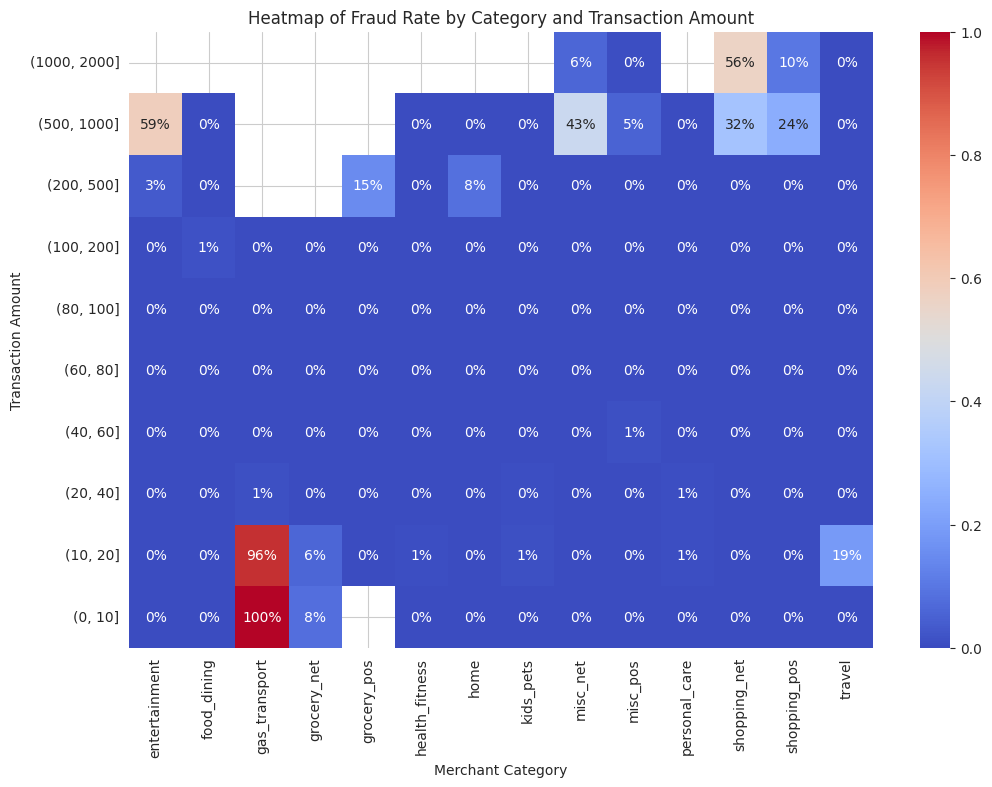

In [37]:
# Calcualte fraud rates by group
grouped = df_train.groupby(['amt_bins', 'category'])
fraud_rate = grouped['is_fraud'].mean().unstack()
fraud_rate = fraud_rate.sort_index(ascending=False)
#freq = grouped.count().unstack()
#fraud_count = grouped['is_fraud'].sum().unstack()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(fraud_rate, annot=True, fmt=".0%", cmap='coolwarm')

# Add labels and title
plt.xlabel('Merchant Category')
plt.ylabel('Transaction Amount')
#plt.xticks(rotation=70)
plt.title('Heatmap of Fraud Rate by Category and Transaction Amount')

# Show the plot
plt.show()

del fraud_rate

/tmp/ipykernel_822/2400536352.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_train.groupby(['amt_bins', 'f_timeofday'])


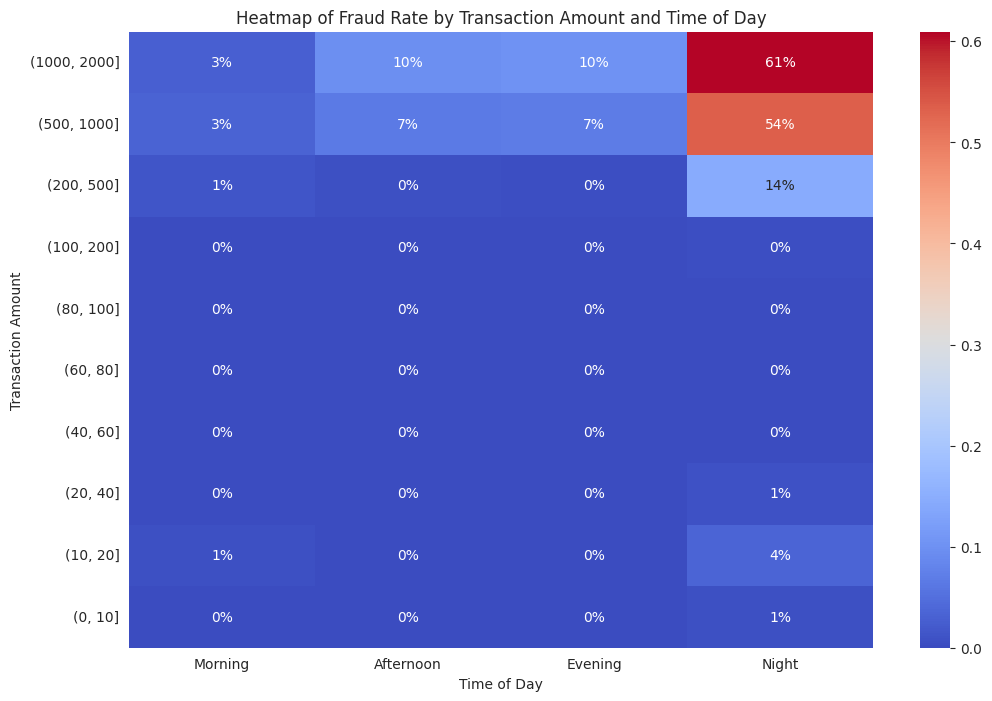

In [38]:
df_train['f_timeofday'] = np.where((df_train.hour >= 4) & (df_train.hour <= 11), 'Morning', 
                                 np.where((df_train.hour >=12) & (df_train.hour <= 16), 'Afternoon',
                                 np.where((df_train.hour >= 17) & (df_train.hour <= 21), 'Evening', 'Night')))

# Calcualte fraud rates by group
grouped = df_train.groupby(['amt_bins', 'f_timeofday'])
fraud_rate = grouped['is_fraud'].mean().unstack()
fraud_rate = fraud_rate[['Morning', 'Afternoon', 'Evening', 'Night']].sort_index(ascending=False)
#freq = grouped.count().unstack()
#fraud_count = grouped['is_fraud'].sum().unstack()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(fraud_rate, annot=True, fmt=".0%", cmap='coolwarm')

# Add labels and title
plt.ylabel('Transaction Amount')
plt.xlabel('Time of Day')
plt.title('Heatmap of Fraud Rate by Transaction Amount and Time of Day')

# Show the plot
plt.show()

del fraud_rate

/tmp/ipykernel_822/4170769501.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_train.groupby(['past_7D_amt_count_bins', 'past_1D_amt_count_bins'])


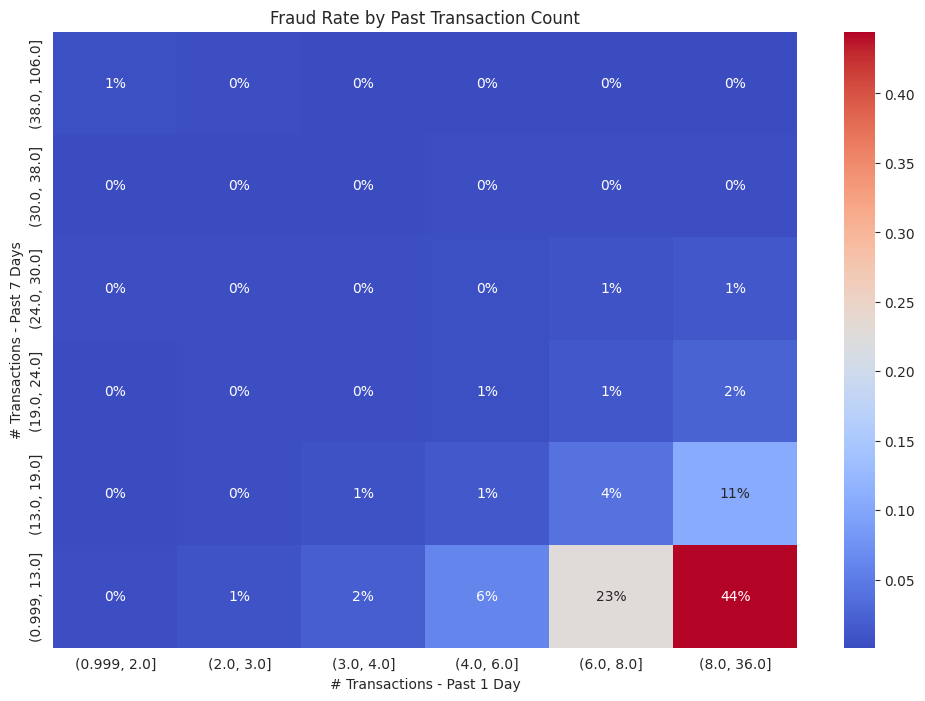

In [39]:

df_train['past_7D_amt_count_bins'] = pd.qcut(df_train.f_past_7D_amt_count, 6)
df_train['past_1D_amt_count_bins'] = pd.qcut(df_train.f_past_1D_amt_count, 6, duplicates='drop')

grouped = df_train.groupby(['past_7D_amt_count_bins', 'past_1D_amt_count_bins'])
fraud_rate = grouped['is_fraud'].mean().unstack()
fraud_rate = fraud_rate.sort_index(ascending=False)
#freq = grouped.count().unstack()
#fraud_count = grouped['is_fraud'].sum().unstack()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(fraud_rate, annot=True, fmt=".0%", cmap='coolwarm')

# Add labels and title
plt.ylabel('# Transactions - Past 7 Days')
plt.xlabel('# Transactions - Past 1 Day')
plt.title('Fraud Rate by Past Transaction Count')

# Show the plot
plt.show()

del fraud_rate

## 5. Modeling

Prepare test data

Note: 
* To prepare the backward looking features, I append the last 60 days of training data to the test set for the calculations. This is to mimic production, where past data is available.
* There are no scaling, target encoding, or forward looking types of features that could cause data leakage.

In [40]:
df_test = pd.read_csv('./data/tr_fincrime_test.csv')

df_test_start_date = df_test.trans_date_trans_time.min()
# check data timeframe
print('Start Date: ', df_test_start_date)
print('End Date:   ', df_test.trans_date_trans_time.max())

# In order to collect features using past data, the last 60 days must be appended to test data

df_last_60 = pd.read_csv('./data/tr_fincrime_train.csv')
df_last_60 = df_last_60.loc[df_last_60.trans_date_trans_time >= '2020-04-21']

# Add previous 60 days of transactions
df_test = pd.concat([df_last_60, df_test], ignore_index=True)

del df_last_60

Start Date:  2020-06-21 12:14:25
End Date:    2020-12-31 23:59:34


In [41]:
# Create features
df_test = process_data(df_test)

# Remove df_train data
df_test = df_test.loc[df_test.trans_date_trans_time >= df_test_start_date]
df_test.reset_index(inplace=True)

Category encoding and data preperation

In [42]:
# Get list of features relevant for modeling
orig_features = ['amt', 'gender', 'city_pop', 'trans_date_trans_time']
features_list = list(df_train.columns[df_train.columns.str.startswith('f_')])
features_list = features_list + orig_features

# Subset columns down to modeling columns
df_train_modeling = df_train[features_list]
df_test_modeling = df_test[features_list]


categorical_features = ['f_month', 'f_dayofweek', 'f_bus_type','f_timeofday','gender', 'f_MII']

enc = OneHotEncoder(sparse=False, handle_unknown='ignore') 


# Fit encoding to training data
enc.fit(df_train_modeling[categorical_features])
enc_feature_names = enc.get_feature_names_out(categorical_features)

# Transform the training data
encoded_train = enc.transform(df_train_modeling[categorical_features])
encoded_train = pd.DataFrame(encoded_train, columns=enc_feature_names)

# Join dataframes
df_train_modeling = pd.concat([df_train_modeling.drop(categorical_features, axis=1), encoded_train], axis=1)

# Prepare train and validate sets
X_train = df_train_modeling.loc[df_train_modeling.trans_date_trans_time<'2020-03-01'].copy()
X_val = df_train_modeling.loc[df_train_modeling.trans_date_trans_time>='2020-03-01'].copy()
X_train.drop(columns='trans_date_trans_time', inplace=True)
X_val.drop(columns='trans_date_trans_time', inplace=True)

y_train = df_train.loc[df_train.trans_date_trans_time<'2020-03-01','is_fraud']
y_val = df_train.loc[df_train.trans_date_trans_time>='2020-03-01','is_fraud']



# Transform the test data
encoded_test = enc.transform(df_test[categorical_features])
encoded_test = pd.DataFrame(encoded_test, columns=enc_feature_names)

# Drop categorical features and join encoded
X_test = pd.concat([df_test_modeling.drop(categorical_features, axis=1), encoded_test], axis=1)
X_test.drop(columns='trans_date_trans_time', inplace=True)


y_test = df_test['is_fraud']

del df_train_modeling
del df_test_modeling
del encoded_train
del encoded_test

/home/blake/anaconda3/envs/trep_study/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [43]:
freq_tab(y_train)

,Frequency,Percent,Cumulative Frequency,Cumulative Percent
is_fraud,,,,
0,1018974,0.994,1018974,0.994
1,5899,0.006,1024873,1.000


In [44]:
freq_tab(y_val)

,Frequency,Percent,Cumulative Frequency,Cumulative Percent
is_fraud,,,,
0,270235,0.994,270235,0.994
1,1607,0.006,271842,1.000


Notes: 
* Because the dataset is highly imbalanced, I will use AUC PR as opposed to measures such as ROC AUC or accuracy
* I didn't have much time to do thorough hyperparameter tuning, so I opted to do a very simple, non exhaustive HP tuning with a holdout sample instead of using CV. Given more time I would do this part more thoroughly.

In [45]:
# Create custom evaluation metric
def lgb_average_precision_score(y_true, y_pred):
    return 'average_precision', average_precision_score(y_true, y_pred), True

In [81]:
# Define the parameter grid
param_grid = {
    'num_leaves': [30, 50],
    'max_depth': [10, -1],
    'min_child_samples': [30, 50]
}


# Manual hyperparameter tuning using the validation set
best_score = float('-inf')
best_params = None

for num_leaves in param_grid['num_leaves']:
    for max_depth in param_grid['max_depth']:
        for min_child_samples in param_grid['min_child_samples']:
            model = lgb.LGBMClassifier(num_leaves=num_leaves, 
                                       max_depth=max_depth, 
                                       min_child_samples=min_child_samples, 
                                       n_estimators=2000,
                                       learning_rate=0.05, 
                                       is_unbalance=True,
                                       random_state= 26)
            model.fit(X_train, y_train)
            model.fit(X_train, y_train, eval_metric=lgb_average_precision_score, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation()])
            # Evaluate on the validation set
            y_scores = model.predict_proba(X_val)[:, 1]
            average_precision = lgb_average_precision_score(y_val, y_scores)
            if average_precision > best_aucpr:
                best_aucpr = average_precision
                best_params = {'best_aucpr': best_aucpr, 'num_leaves': num_leaves, 'max_depth': max_depth, 'min_child_samples': min_child_samples}

print("Best parameters found: ", best_params)
# Disregard the output (the parameters printed are from an incorrect run)

[LightGBM] [Info] Number of positive: 5899, number of negative: 1018974
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4994
[LightGBM] [Info] Number of data points in the train set: 1024873, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005756 -> initscore=-5.151769
[LightGBM] [Info] Start training from score -5.151769
[LightGBM] [Info] Number of positive: 5899, number of negative: 1018974
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4994
[LightGBM] [Info] Number of data points in the train set: 1024873, number of used features: 68
[LightGBM] [

In [46]:
# Train final model
clf = lgb.LGBMClassifier(
    num_leaves=50,
    learning_rate=0.05,
    n_estimators=2000,
    min_child_samples=30,
    is_unbalance=True,
    random_state= 26 
)

# Fit the model
clf.fit(X_train, y_train, eval_metric=lgb_average_precision_score, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation()])

# Save final model
with open('final_model2.pkl', 'wb') as file:
    pickle.dump(clf, file)

[LightGBM] [Info] Number of positive: 5899, number of negative: 1018974
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.174272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4978
[LightGBM] [Info] Number of data points in the train set: 1024873, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005756 -> initscore=-5.151769
[LightGBM] [Info] Start training from score -5.151769
[1]	valid_0's binary_logloss: 0.100954	valid_0's average_precision: 0.289609
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.101049	valid_0's average_precision: 0.483245
[3]	valid_0's binary_logloss: 0.0973678	valid_0's average_precision: 0.50409
[4]	valid_0's binary_logloss: 0.096814	valid_0's average_precision: 0.586207
[5]	valid_0's binary_logloss: 0.0944809	valid_0's average_precision: 0

/home/blake/anaconda3/envs/trep_study/lib/python3.12/site-packages/lightgbm/plotting.py:381: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='average_precision'>

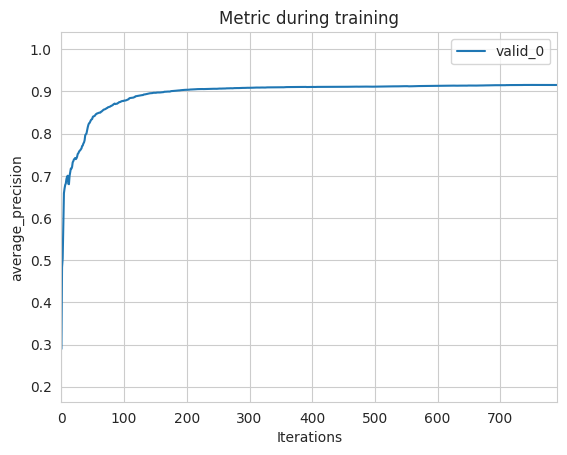

In [47]:
lgb.plot_metric(clf)

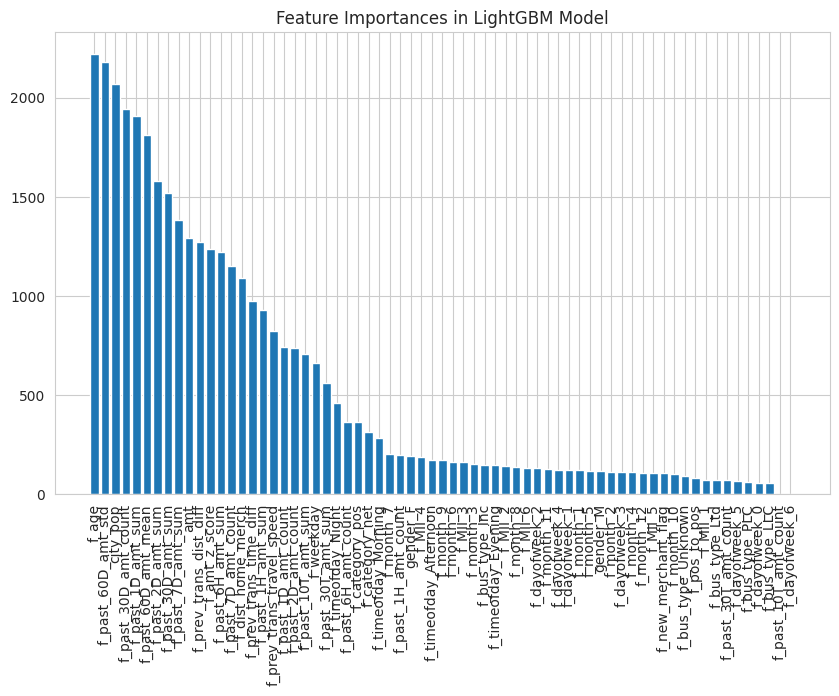

In [48]:
importances = clf.feature_importances_
feature_names = list(clf.feature_name_)

# Create a bar chart of feature names
sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_names)), importances[sorted_idx], align='center')
plt.xticks(range(len(feature_names)), [feature_names[i] for i in sorted_idx], rotation=90) 
plt.title("Feature Importances in LightGBM Model")
plt.show()

In [15]:
# Load model 
with open('final_model2.pkl', 'rb') as file:
    clf = pickle.load(file)

In [49]:
clf.score

<bound method ClassifierMixin.score of LGBMClassifier(is_unbalance=True, learning_rate=0.05, min_child_samples=30,
               n_estimators=2000, num_leaves=50, random_state=26)>

In [50]:
# Calculated score for fraud class
y_scores = clf.predict_proba(X_test)[:,1]

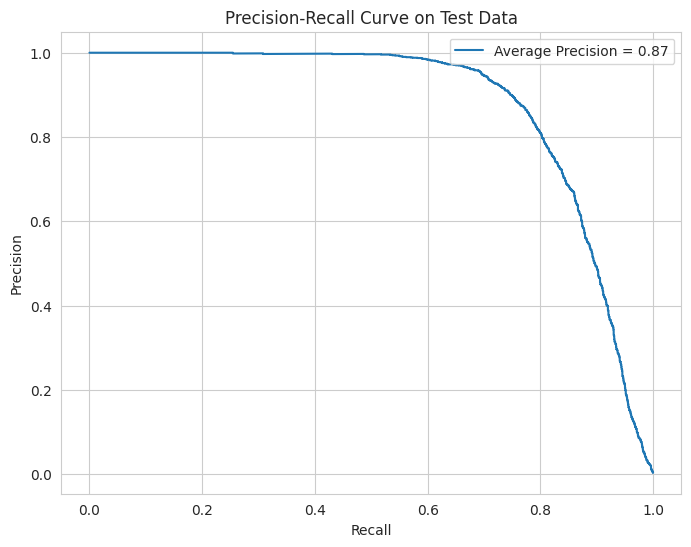

In [51]:
# Continue with the calculation of precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

# Plotting the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Average Precision = {average_precision:0.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Test Data')
plt.legend(loc="best")
plt.show()

In [52]:
# Create capture rate table
y_scores_0 = clf.predict_proba(X_test)[:,0] # This will reverse the order so frauds at bottom

score_df = pd.DataFrame({'scores':y_scores_0, 'fraud':y_test})

score_df.scores = pd.qcut(score_df.scores, 20)
single_bivar(score_df, 'scores', 'fraud')

/home/blake/anaconda3/envs/trep_study/lib/python3.12/site-packages/scoretools/smalltables.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gdat = gdat.groupby(main_var)


,N,Pct N,fraud sum,fraud Rate,fraud Pct
scores,,,,,
"(2.1058562e-08, 0.99975284]",27789.000,0.050,2102.000,0.076,0.980
"(0.99975284, 0.99994496]",27788.000,0.050,17.000,0.001,0.008
"(0.99994496, 0.99997471]",27788.000,0.050,10.000,0.000,0.005
"(0.99997471, 0.99998577]",27789.000,0.050,8.000,0.000,0.004
"(0.99998577, 0.99999123]",27788.000,0.050,0.000,0.000,0.000
"(0.99999123, 0.99999429]",27788.000,0.050,1.000,0.000,0.000
"(0.99999429, 0.99999613]",27789.000,0.050,1.000,0.000,0.000
"(0.99999613, 0.99999733]",27788.000,0.050,1.000,0.000,0.000
"(0.99999733, 0.99999813]",27788.000,0.050,2.000,0.000,0.001


In [53]:
score_df = pd.DataFrame({'scores':y_scores_0, 'fraud':y_test})
score_df.scores = pd.qcut(score_df.scores, 100)
single_bivar(score_df, 'scores', 'fraud')[:20]

/home/blake/anaconda3/envs/trep_study/lib/python3.12/site-packages/scoretools/smalltables.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gdat = gdat.groupby(main_var)


,N,Pct N,fraud sum,fraud Rate,fraud Pct
scores,,,,,
"(3.00585616e-08, 0.957041338]",5558.000,0.010,1988.000,0.358,0.927
"(0.957041338, 0.995061199]",5558.000,0.010,57.000,0.010,0.027
"(0.995061199, 0.998785531]",5557.000,0.010,27.000,0.005,0.013
"(0.998785531, 0.999533473]",5558.000,0.010,15.000,0.003,0.007
"(0.999533473, 0.999752837]",5558.000,0.010,15.000,0.003,0.007
"(0.999752837, 0.999840938]",5557.000,0.010,3.000,0.001,0.001
"(0.999840938, 0.999886996]",5558.000,0.010,3.000,0.001,0.001
"(0.999886996, 0.999914181]",5558.000,0.010,6.000,0.001,0.003
"(0.999914181, 0.999932574]",5557.000,0.010,2.000,0.000,0.001


## 6. Final Thoughts

Given more time, there are many more ideas that I would like to look into. A few examples:
* Implementing an anomaly detection algorithm (ex. Iso forest). Possibly incorporate this as a feature
* Some customers have fraudulent transactions from the first transaction. This indicates ID theft, or a different type of fraud than a stolen credit card. It would be interesting to split these customers apart, and possible create a seperate model (or ensemble method) with them.
* For business purposes, the first fraudulent transaction on a customer account is the most important to catch, as it prevents further frauds on the account. These could also be inspected closer, especially with more features around the change in behavior (velocity features).
* I created quite a few features for this model, but there's still a lot more to be explored.
